# Here is an example that illustrates how VAE-CME works in Bursty model
The Bursty model considers that the gene is transcribed by RNA polymerase II (Pol II), which binds to the promoter and initiates the production of nascent mRNA ($N$). The birth of nascent mRNA occurs in bursts and after a fixed time interval $\tau$, Pol II detaches from the gene. The size of each burst, denoted as $i$, follows a geometric distribution given by $b^i/(1 + b)^{i+1}$.  This behavior can be represented through a reaction scheme
$$
\varnothing\stackrel{\frac{\alpha b^i}{(1+b)^{i+1}}}\longrightarrow iN,i=1,2,3,...\\ N\stackrel{\tau}\Rightarrow\varnothing,
$$
where $\alpha$ represents the burst frequency and $b$ denotes the mean burst size. 

The variational autoencoder chemical master equation of Bursty model is

$$
\partial_t P(n,t) = \sum_{m=1}^{\infty} \frac{\alpha b^m}{(1+b)^{m+1}}
\left[ P(n-m,t) - P(n,t) \right] + \\
\text{NN}_\theta(n+1,t)P(n+1,t) - \text{NN}_\theta(n,t)P(n,t).
$$

We can rewrite the closed form of original VAE-CME as

$$
\frac{\text{d} \mathbf{P}(t)}{\text{d}t}=\mathbf{A}_\theta(t)\mathbf{P}(t),
$$

and $\mathbf{A}_\theta (t)=\mathbf{D}+\mathbf{N}_\theta(t)$ are defined as 
$$
\mathbf{D} = \begin{bmatrix}
-\frac{\alpha b}{1+b} & 0 & \cdots & 0 & 0 \\
\frac{\alpha b}{(1+b)^2} & -\frac{\alpha b}{1+b} & \cdots & 0 & 0 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
\frac{\alpha b^{N-1}}{(1+b)^N} & \frac{\alpha b^{N-2}}{(1+b)^{N-1}} & \cdots & -\frac{\alpha b}{1+b} & 0 \\
\frac{\alpha b^N}{(1+b)^{N+1}} & \frac{\alpha b^{N-1}}{(1+b)^N} & \cdots & \frac{\alpha b}{(1+b)^2} & -\frac{\alpha b}{1+b}
\end{bmatrix},
$$
and

$$
\mathbf{N}_\theta(t) = \begin{bmatrix}
0 & \text{NN}_\theta(1,t) & \cdots & 0 & 0 \\
0 & -\text{NN}_\theta(1,t) & \cdots & 0 & 0 \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
0 & 0 & \cdots & -\text{NN}_\theta(N-1,t) & \text{NN}_\theta(N,t) \\
0 & 0 & \cdots & 0 & -\text{NN}_\theta(N,t)
\end{bmatrix}. 
$$

In [1]:
# Import packages
using Flux, DiffEqSensitivity, DifferentialEquations
using Distributions, Distances
using DelimitedFiles, Plots
include("utils.jl")

bursty_delay (generic function with 1 method)

## Load training data

In [2]:
train_sol = readdlm("Fig3def/data/Bursty.txt")

65×1201 Matrix{Float64}:
 1.0  0.97836      0.957189    0.936476    …  0.0724212    0.0724212
 0.0  0.00479904   0.00939038  0.0137808      0.0426288    0.0426288
 0.0  0.00373479   0.00733098  0.0107923      0.0456169    0.0456169
 0.0  0.00290655   0.00572314  0.00845166     0.0475836    0.0475836
 0.0  0.00226197   0.00446788  0.00661847     0.0486471    0.0486471
 0.0  0.00176033   0.0034879   0.00518275  …  0.0489277    0.0489277
 0.0  0.00136994   0.00272282  0.00405836     0.0485437    0.0485437
 0.0  0.00106612   0.00212554  0.00317782     0.0476077    0.0476077
 0.0  0.000829677  0.00165926  0.00248825     0.0462244    0.0462244
 0.0  0.00064567   0.00129525  0.00194827     0.0444896    0.0444896
 ⋮                                         ⋱               ⋮
 0.0  4.90111e-9   1.12551e-8  1.92381e-8     0.000191224  0.000191224
 0.0  3.81359e-9   8.78127e-9  1.50467e-8     0.000164416  0.000164416
 0.0  2.96737e-9   6.85113e-9  1.17682e-8     0.000141255  0.000141255
 0.0  2.308

## Define Truncation, kinetic parameters and time delay

In [3]:
# Truncation
N = 64

# Kinetic parameters and time delay
a = 0.0282
b = 3.46
τ = 120;

## Model initialization

In [4]:
latent_size = 10;
encoder = Chain(Dense(N+1, 20,tanh),Dense(20, latent_size * 2));
decoder = Chain(Dense(latent_size, 20,tanh),Dense(20, N),x-> 0.03*x.+[i/120  for i in 1:N],x ->relu.(x));

params1, re1 = Flux.destructure(encoder);
params2, re2 = Flux.destructure(decoder);
ps = Flux.params(params1,params2);

## Define the VAE-CME

In [5]:
function CME(du, u, p, t)
    h = re1(p[1:length(params1)])(u)
    μ, logσ = split_encoder_result(h, latent_size)
    z = reparameterize.(μ, logσ, p[end-latent_size+1:end])
    NN = re2(p[length(params1)+1:end-latent_size])(z)

    du[1] = (-a*b/(1+b))*u[1] + NN[1]*u[2];
    for i in 2:N
            du[i] =  (-a*b/(1+b) - NN[i-1])*u[i] + NN[i]*u[i+1];
            for j in 1:i-1
                    du[i] += (a*(b/(1+b))^j/(1+b)) * u[i-j]
            end
    end
    du[N+1] = (-a*b/(1+b) - NN[N])*u[N+1];
    for j in 1:N
            du[N+1] += (a*(b/(1+b))^j/(1+b)) * u[N+1-j]
    end
end;

## Read trained VAE parameters

In [6]:
using CSV,DataFrames
df = CSV.read("Fig3def/params_trained/Bursty.csv",DataFrame)
params1 = df.params1
params2 = df.params2[1:length(params2)];

## Solve the ODE

In [8]:
u0 = [1.; zeros(N)]
tf = 1200
tspan = (0, tf)
saveat = 0:1:tf
ϵ = zeros(latent_size)
params_all = [params1;params2;ϵ];
problem = ODEProblem(CME, u0, tspan, params_all);
solution = Array(solve(problem,Tsit5(),u0=u0,p=params_all,saveat=saveat))

65×1201 Matrix{Float64}:
 1.0  0.978363     0.957198     0.936495    …  0.0705348    0.0705338
 0.0  0.00479717   0.00938301   0.0137645      0.041886     0.0418854
 0.0  0.00373704   0.00733978   0.0108117      0.0450658    0.0450652
 0.0  0.00290589   0.00572058   0.00844603     0.0468523    0.0468517
 0.0  0.00226207   0.00446828   0.00661937     0.0473379    0.0473373
 0.0  0.00176117   0.00349127   0.00519031  …  0.0475809    0.0475803
 0.0  0.00136962   0.0027216    0.00405572     0.0475133    0.0475127
 0.0  0.00106623   0.002126     0.0031789      0.0469449    0.0469443
 0.0  0.000829697  0.00165938   0.00248859     0.0452302    0.0452296
 0.0  0.000646054  0.0012968    0.00195181     0.0436114    0.0436108
 ⋮                                          ⋱               ⋮
 0.0  4.47222e-9   9.45975e-9   1.49941e-8     0.000304045  0.000304045
 0.0  3.43903e-9   7.28758e-9   1.16033e-8     0.000205851  0.000205849
 0.0  2.83583e-9   6.17727e-9   1.00095e-8     0.000119725  0.0001197

## Check the probability distribution

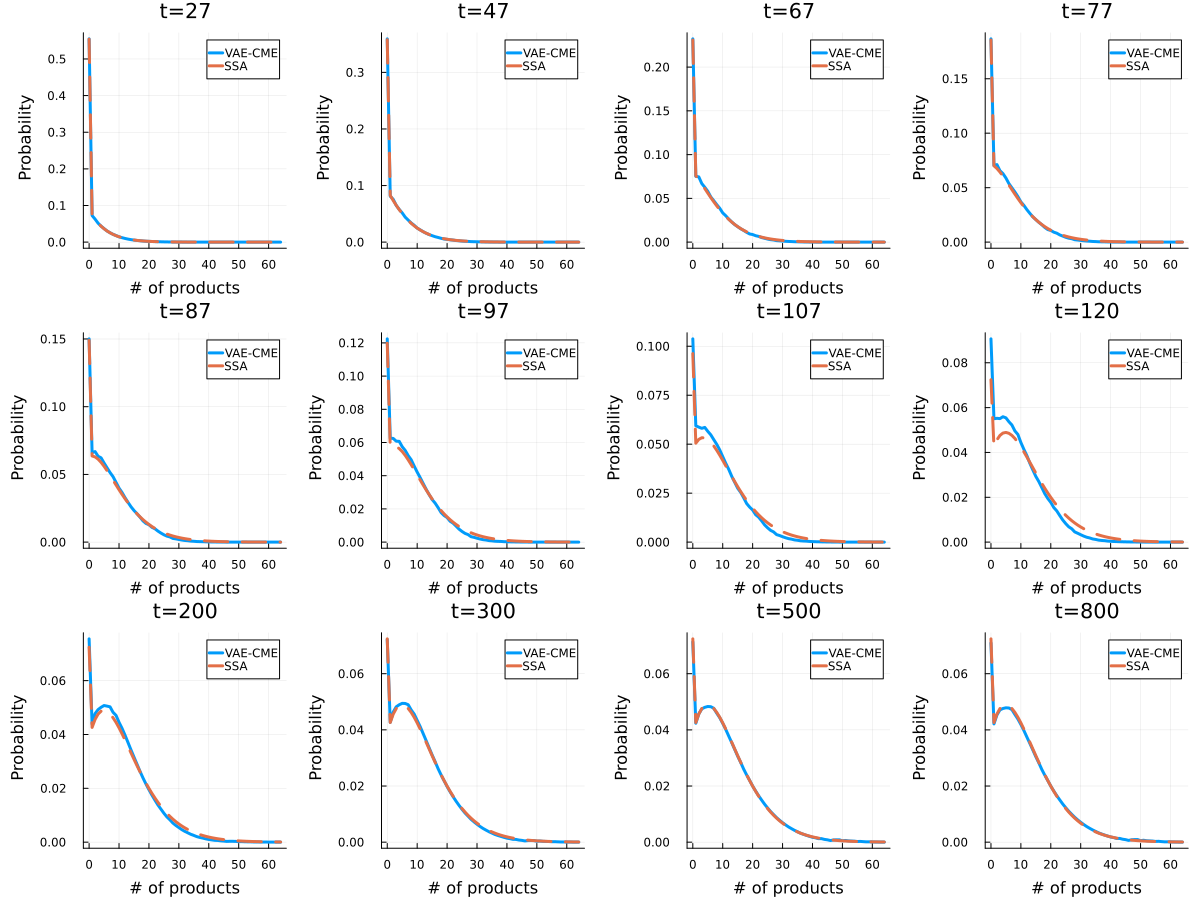

In [9]:
function plot_distribution(time_choose)
    p=plot(0:N,solution[:,time_choose+1],linewidth = 3,label="VAE-CME",xlabel = "# of products", ylabel = "\n Probability")
    plot!(0:N,train_sol[:,time_choose+1],linewidth = 3,label="SSA",title=join(["t=",time_choose]),line=:dash)
    return p
end

function plot_all()
    p1 = plot_distribution(27)
    p2 = plot_distribution(47)
    p3 = plot_distribution(67)
    p4 = plot_distribution(77)
    p5 = plot_distribution(87)
    p6 = plot_distribution(97)
    p7 = plot_distribution(107)
    p8 = plot_distribution(120)
    p9 = plot_distribution(200)
    p10 = plot_distribution(300)
    p11 = plot_distribution(500)
    p12 = plot_distribution(800)
    plot(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,size=(1200,900))
end
plot_all()